# Neural Network from Scratch

The following code implements a simple neural network with $depth=1$ (only one hidden layer). 
* The sigmoid function is used as activation function.
* Weights and biases are initialized with random values.
* The network adapts to any number of features and outputs, as long as $\text{[number of outputs]} < \text{[number of feautures]}$. 
* The number of nodes in the hidden layer is calculated as the average between $\text{[number of feautures]}$  and $\text{[number of outputs]}$, rounded up.


Inspired by [An Introduction to Neural Networks](https://victorzhou.com/blog/intro-to-neural-networks/). This version extends the functionality to any number of features and outputs.

---


### Defining NeuralNetwork class and required functions

In [72]:
import math
import numpy as np

np.random.seed(123)

def sigmoid(x):
    # Sigmoid activation function: f(x) = 1 / (1 + e^(-x))
    return 1 / (1 + np.exp(-x))

def deriv_sigmoid(x):
    # Derivative of sigmoid: f'(x) = f(x) * (1 - f(x))
    fx = sigmoid(x)
    return fx * (1 - fx)

def mse_loss(y_true, y_pred):
    return ((y_true - y_pred) ** 2).mean()

class NeuralNetwork:
    def __init__(self, number_features, number_outputs):
        number_hidden_layers = math.ceil((number_features + number_outputs) / 2)
        # Weights
        self.w_1 = np.random.normal(size=(number_features, number_hidden_layers))
        self.w_2 = np.random.normal(size=(number_hidden_layers, number_outputs))
        #Biases
        self.b_1 = np.random.normal(size=(number_hidden_layers))
        self.b_2 = np.random.normal(size=(number_outputs))

    def feedforward(self, x):   
        h = sigmoid(np.dot(x, np.transpose(self.w_1)) + self.b_1)
        o1 = sigmoid(np.dot(h, self.w_2) + self.b_2)
        return o1

    def train(self, X_train, y_train):
        learn_rate = 0.1
        epochs = 1000 # number of times to loop through the entire dataset
        epoch_list = []
        loss_list = []

        for epoch in range(epochs):
            for x, y_true in zip(X_train, y_train):
                sum_h = np.dot(x, np.transpose(self.w_1)) + self.b_1
                h = sigmoid(sum_h)

                sum_o1 = np.dot(h, self.w_2) + self.b_2
                o1 = sigmoid(sum_o1)
                y_pred = o1[0]

                # --- Calculate partial derivatives.
                d_L_d_ypred = -2 * (y_true - y_pred)

                # Neuron o1
                d_ypred_d_w2 = h * deriv_sigmoid(sum_o1)
                d_ypred_d_b2 = deriv_sigmoid(sum_o1)
                d_ypred_d_h = self.w_2 * deriv_sigmoid(sum_o1)

                # Neurons in hidden layer
                d_h1_d_w1 = x.reshape(len(x),1) * deriv_sigmoid(sum_h)
                d_h1_d_b1 = deriv_sigmoid(sum_h)

                # --- Update weights and biases
                # Neurons in hidden layer
                self.w_1 -= np.transpose(learn_rate * np.transpose(d_h1_d_w1) * d_L_d_ypred * d_ypred_d_h)
                self.b_1 -= (learn_rate * d_L_d_ypred * d_ypred_d_h * d_h1_d_b1.reshape(len(d_h1_d_b1), 1)).reshape(len(self.b_1))

                # Neuron o1
                self.w_2 -= (learn_rate * d_L_d_ypred * d_ypred_d_w2).reshape(len(self.w_2), 1)
                self.b_2 -= learn_rate * d_L_d_ypred * d_ypred_d_b2
            
            # --- Calculate total loss at the end of each epoch
            if epoch % 10 == 0:
                y_preds = np.apply_along_axis(self.feedforward, 1, X_train)
                loss = mse_loss(y_train, y_preds.reshape(len(y_preds)))
                epoch_list.append(epoch)
                loss_list.append(loss)
        
        return pd.DataFrame({'Epoch': epoch_list, 'Loss': loss_list})

### Importing data

In [82]:
import pandas as pd

df_train = pd.read_csv("./data/train_data.csv")
df_train

,Name,Weight (lb),Weight (kg),Height (in),Height (cm),Gender
0,Alice,133,60.327777,65,165.10,F
1,Bob,160,72.574770,72,182.88,M
2,Charlie,152,68.946031,70,177.80,M
3,Diana,120,54.431077,60,152.40,F


### Transforming DataFrame

In [83]:
df_train = df_train.drop(['Weight (lb)', 'Height (in)'], axis=1)

# Centering the data substraction the mean
avg_weight = df_train['Weight (kg)'].mean()
avg_height = df_train['Height (cm)'].mean()
df_train['Weight (kg)'] = df_train['Weight (kg)'] - avg_weight
df_train['Height (cm)'] = df_train['Height (cm)'] - avg_height
df_train.rename(columns={"Weight (kg)": "Weight_dev", "Height (cm)": "Height_dev"}, inplace=True)

df_train['Gender'] = df_train['Gender'].apply(lambda x: 1 if x == 'F' else (0 if x == 'M' else np.NaN))

df_train

,Name,Weight_dev,Height_dev,Gender
0,Alice,-3.742137,-4.445,1
1,Bob,8.504856,13.335,0
2,Charlie,4.876117,8.255,0
3,Diana,-9.638837,-17.145,1


### Dividing data into features and target

In [84]:
X_train = df_train[['Weight_dev', 'Height_dev']].to_numpy()
y_train = df_train['Gender'].to_numpy()

### Instantiating and training a neural Network

In [85]:
network = NeuralNetwork(2,1) # number_features=2, number_outputs=1
loss = network.train(X_train, y_train)

### Looking at the results

Text(0, 0.5, 'Loss')

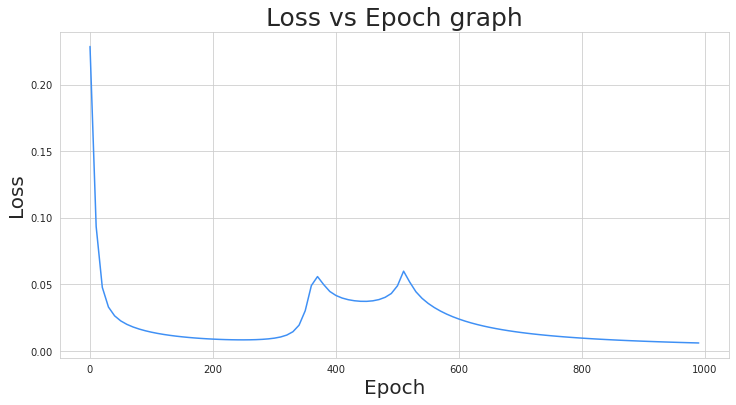

In [86]:
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.dates import MonthLocator, DateFormatter
from matplotlib.ticker import (MultipleLocator, AutoMinorLocator, NullFormatter)
sns.set_style('whitegrid') 

f, ax = plt.subplots(figsize=(12, 6))
lp = sns.lineplot(data=loss, x="Epoch", y="Loss", color="#3F90F5", ax=ax)
lp.axes.set_title("Loss vs Epoch graph",fontsize=25)
lp.set_xlabel("Epoch",fontsize=20)
lp.set_ylabel("Loss", fontsize=20)

### Making predictions

In [90]:
emily = np.array([54, 160])
frank = np.array([70, 174])

# Substracting averages
avgs = np.array([avg_weight, avg_height])
emily = emily - avgs
frank = frank - avgs

In [92]:
def get_prediction(value):
    return 'Female' if value > 0.5 else 'Male'

In [93]:
print("Emily: %s" % get_prediction(network.feedforward(emily)))
print("Frank: %s" % get_prediction(network.feedforward(frank)))

Emily: Female
Frank: Male
